# Fake News Assignment
**Authors**: Vilhelm Stiernstedt & Sharon Marín Salazar
<br>
**Date**: 20/05/2018

### Description
Classification problem of News Report (document) for classes (FAKE, REAL). Try text-related classifiers such as Naive Bayes, MaxEnt, SVM. Use NLTK+SKLearn, NLP Pre-processing, Classifiers and CV-evaluation.

#### Dataset
**fake_or_real_news_training:**
- ID: ID of the tweet
- Title: Title of the news report
- Text: Textual content of the news report
- Label: Target Variable [FAKE, REAL]
- X1, X2 additional fields

**fake_or_real_news_test:**
- ID, title and text
- Predict Label

#### Advices
- Take a look to the data
- Try the pre-processing methodologies we have seen in class
- TF-IDF seems to be better (but try it!)
- N-grams pay the effort
- Less than 90-92%? -> Try again

#### Plan
1. Variable analysis
2. Variable manipulation
3. Modelling
    - Navie Bayes
    - MaxEnt
    - SVM
4. Evaluation

## Import Libraries

In [171]:
import collections
import matplotlib.pyplot as plt
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import seaborn as sns
import re
import PipelineHelper # https://github.com/bmurauer/pipelinehelper/blob/master/pipelinehelper.py
from scipy.sparse import hstack
from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
import warnings

# download required nltk packages (NB. commented out)
# nltk.download()

# plot settings
%matplotlib inline

# pandas view settings -> see all contents of column
pd.set_option('display.max_colwidth', -1)

# Warning settings -> suppress depreciation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Import Data

In [172]:
# set path to data
data_path = 'data/'

# load test and train
df_train = pd.read_csv(data_path+'fake_or_real_news_training.csv')
df_test = pd.read_csv(data_path+'fake_or_real_news_test.csv')

# set index
df_train.set_index('ID', inplace=True)
df_test.set_index('ID', inplace=True)

# define combined df
all_data = df_train.append(df_test)

### Function Definitions

In [266]:
# define stop words
stop_words = set(stopwords.words('english'))

# define lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# create normalization function
def normalizer(text):
    clean_text = re.sub('[^\x00-\x7F]+', "", text) # remove non-ascii characters
    clean_text = re.sub('(\r)+', "",  clean_text) # remove newline characters
    clean_text = re.sub(r'@([A-Za-z0-9_]+)', "",  clean_text) # remove twitter handles
    clean_text = re.sub(r"(https|http)\S+", "",  clean_text) # remove hyperlinks
    clean_text = re.sub("[^a-zA-Z]", " ", clean_text) # remove all but letters remains
    tokens = nltk.word_tokenize(clean_text)[2:] # tokenize words
    lower_case = [l.lower() for l in tokens] # convert to lowercase
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) # filter stopwords
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] # stem words with lemmatizer
    return lemmas

# define function to construct our ngrams
def ngrams(input_list):
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    quadgrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[3:]))]
    return bigrams+trigrams+quadgrams

# define function to count words
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

# exclaimation counter
def exclaimation_counter(article):
    nr = article.count('!')
    return nr

## Inspect Data

### Structure and features

In [205]:
# check dimension of training data
df_train.shape

(3999, 7)

In [206]:
# check dimension of test data -> more than one column difference!
df_test.shape

(2321, 2)

In [207]:
# check column names and dtypes for training data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 8476 to 9673
Data columns (total 7 columns):
title               3999 non-null object
text                3999 non-null object
label               3999 non-null object
X1                  33 non-null object
X2                  2 non-null object
title_normalized    3999 non-null object
title_grams         3999 non-null object
dtypes: object(7)
memory usage: 409.9+ KB


In [208]:
# check column names and dtypes for test data
# -> X1 and X2 not in testset ... -> need manipulation to be used for modelling
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 10498 to 4330
Data columns (total 2 columns):
title    2321 non-null object
text     2321 non-null object
dtypes: object(2)
memory usage: 54.4+ KB


In [209]:
# check df_train -> text lengthy ...
# df_train.head(1)

In [210]:
# check df_test -> similar structure as train -> good.
df_test.head(1)

,title,text
ID,,
10498,September New Homes Sales Rise——-Back To 1992 Level!,"September New Homes Sales Rise Back To 1992 Level! By David Stockman. Posted On Wednesday, October 26th, 2016 \n\nDavid Stockman's Contra Corner is the only place where mainstream delusions and cant about the Warfare State, the Bailout State, Bubble Finance and Beltway Banditry are ripped, refuted and rebuked. Subscribe now to receive David Stockman’s latest posts by email each day as well as his model portfolio, Lee Adler’s Daily Data Dive and David’s personally curated insights and analysis from leading contrarian thinkers."


### Missing values

In [211]:
# missing values for training data -> X1 and X2 almost 100% NaNs -> probably drop values
df_train.isnull().sum()

title               0   
text                0   
label               0   
X1                  3966
X2                  3997
title_normalized    0   
title_grams         0   
dtype: int64

In [212]:
# missing values for training data -> all unnamed almost 100% NaNs, tweet_coord 90%
df_test.isnull().sum()

title    0
text     0
dtype: int64

## Variable Analysis

### X1

In [213]:
# general overview -> mostly unique titles, 4 identical could suggest duplictes exist. 
df_train.X1.describe()

count     33  
unique    4   
top       REAL
freq      17  
Name: X1, dtype: object

In [214]:
# view rows where X1 != NaN
# value counts -> seems that variable include data that has miss aligned
# lets look at independet rows and see the values belong to other column
# either title is long been splitted into both fields (title and text) and thus shifted everything else rightwards
# df_train[df_train.X1.notnull()]

In [215]:
# title merge test -> works!
df_train.loc[599]['title'] + '' + df_train.loc[599]['text']

'Election Day: No Legal Pot In Ohio Democrats Lose In The SouthElection Day: No Legal Pot In Ohio; Democrats Lose In The South\n\nTuesday is "off year" Election Day in parts of the country. Legalizing marijuana is on the ballot in Ohio, Houston voters will decide on an equal rights ordinance and San Francisco weighs short-term rentals in what\'s being called the "Airbnb Initiative."\n\nElsewhere, eyes are on governor races in Kentucky and Louisiana, and whether Democrats can make any progress in the South.\n\nHere\'s a look at some of the races:\n\nHouston voters will decide whether to keep an equal rights ordinance that was approved by the City Council last year. The Houston Equal Rights Ordinance (HERO) would ban discrimination based on sexual orientation and gender identity — criteria not covered by national anti-discrimination laws. The ordinance is hotly debated, particularly after some opposition ads were released. The ads claim that the ordinance would allow men who identify as 

In [216]:
# build function to shift all row fields left where X1 != NaN
for id in df_train[df_train.X1.notnull()].index:
    # title will be a concatenation of title and text
    df_train.loc[id]['title'] = df_train.loc[id]['title'] + '' + df_train.loc[id]['text']
    # text will be current label
    df_train.loc[id]['text'] = df_train.loc[id]['label']
    # label will be current X1
    df_train.loc[id]['label'] = df_train.loc[id]['X1']

In [217]:
# preview X1 again -> looks good
# df_train[df_train.X1.notnull()]

####  notes
At this stage X1 doesn't contain any useful data, we can remove it completely.

### X2

In [218]:
# general overview -> mostly unique titles, 4 identical could suggest duplictes exist. 
df_train.X2.describe()

count     2   
unique    2   
top       FAKE
freq      1   
Name: X2, dtype: object

In [219]:
# view rows where X2 != NaN
# seems that variable include data that has miss aligned just like X1
# from our last shift, we only need to merge title and text, move label to text, and X2 to label
# df_train[df_train.X2.notnull()]

In [220]:
# build function to shift all row fields left where X2 != NaN
for id in df_train[df_train.X2.notnull()].index:
    # title will be a concatenation of title and text
    df_train.loc[id]['title'] = df_train.loc[id]['title'] + '' + df_train.loc[id]['text']
    # text will be current label
    df_train.loc[id]['text'] = df_train.loc[id]['label']
    # label will be current X2
    df_train.loc[id]['label'] = df_train.loc[id]['X2']

In [221]:
# preview X2 again -> looks good
# df_train[df_train.X2.notnull()]

####  notes
At this stage X2 doesn't contain any useful data, we can remove it completely.

### label

In [222]:
# most important is that labels are corrct -> yes, only fake and real!
# also almost equal split of fake and real articles
df_train.label.value_counts()

REAL    2008
FAKE    1991
Name: label, dtype: int64

### title

In [223]:
# general overview -> mostly unique titles, 4 identical could suggest duplictes exist. 
df_train.title.describe()

count     3999                         
unique    3968                         
top       OnPolitics | 's politics blog
freq      4                            
Name: title, dtype: object

#### wordcloud - Fake news
Most common word used in fake news titles.

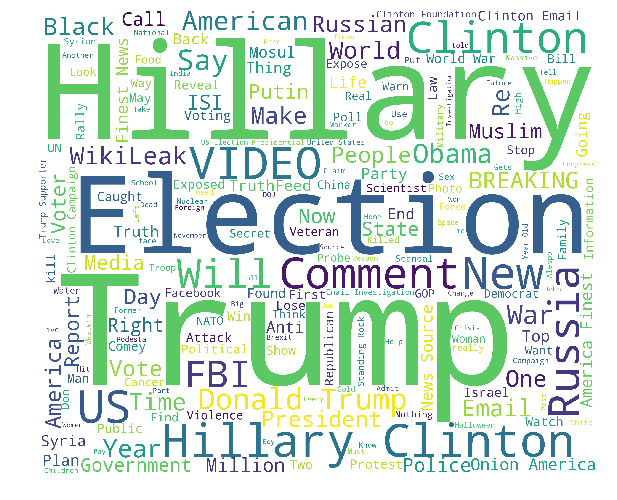

In [193]:
# subset for negative sentiment
df_cloud = df_train[df_train['label']=='FAKE']

# subset all words in text based on space
words = ' '.join(df_cloud['title'])

# split words
split_words = " ".join([word for word in words.split()])

# create wordcloud based on word frequancy
wordcloud = WordCloud(stopwords=STOPWORDS, # remove stopwords
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(split_words)

# plot wordcloud
plt.figure(1, figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### wordcloud - Real news
Most common word used in real news titles.

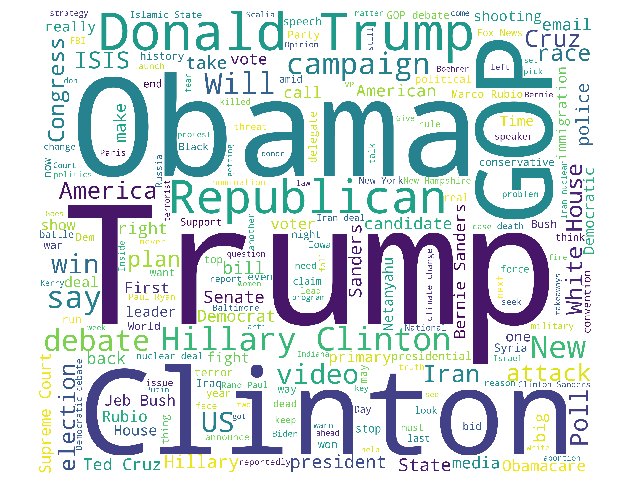

In [194]:
# subset for negative sentiment
df_cloud = df_train[df_train['label']=='REAL']

# subset all words in text based on space
words = ' '.join(df_cloud['title'])

# split words
split_words = " ".join([word for word in words.split()])

# create wordcloud based on word frequancy
wordcloud = WordCloud(stopwords=STOPWORDS, # remove stopwords
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(split_words)

# plot wordcloud
plt.figure(1, figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### normalize text
Lets try to structure the titles and remove all unuseful elements to conduct a better analysis. Such as:
- Remove all but letters
- Tokenize words
- Convert to lowercase
- Filter stopwords
- Stem words with lemmatizer

In [224]:
# create new feature -> apply function on text
df_train['title_normalized'] = df_train.title.apply(normalizer)

# view reuslts -> some desired words seem to fall off, perhaps lammatizer not best tool for stemming.
# We will try other methods for our modelling such as snowball and porter stemmers.
df_train[['title','title_normalized', 'label']].head()

,title,title_normalized,label
ID,,,
8476,You Can Smell Hillary’s Fear,"[smell, hillary, fear]",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO),"[exact, moment, paul, ryan, committed, political, suicide, trump, rally, video]",FAKE
3608,Kerry to go to Paris in gesture of sympathy,"[go, paris, gesture, sympathy]",REAL
10142,Bernie supporters on Twitter erupt in anger against the DNC: 'We tried to warn you!',"[twitter, erupt, anger, dnc, tried, warn]",FAKE
875,The Battle of New York: Why This Primary Matters,"[new, york, primary, matter]",REAL


#### ngrams
As words mostly matter in context we'll look at bi, tri, quad-grams instead of just individual tokens.

In [225]:
# create new feature -> apply function on normalized_text
df_train['title_grams'] = df_train.title_normalized.apply(ngrams)

# view reuslts
df_train[['title_grams']].head()

,title_grams
ID,
8476,"[smell hillary, hillary fear, smell hillary fear]"
10294,"[exact moment, moment paul, paul ryan, ryan committed, committed political, political suicide, suicide trump, trump rally, rally video, exact moment paul, moment paul ryan, paul ryan committed, ryan committed political, committed political suicide, political suicide trump, suicide trump rally, trump rally video, exact moment ryan, moment paul committed, paul ryan political, ryan committed suicide, committed political trump, political suicide rally, suicide trump video]"
3608,"[go paris, paris gesture, gesture sympathy, go paris gesture, paris gesture sympathy, go paris sympathy]"
10142,"[twitter erupt, erupt anger, anger dnc, dnc tried, tried warn, twitter erupt anger, erupt anger dnc, anger dnc tried, dnc tried warn, twitter erupt dnc, erupt anger tried, anger dnc warn]"
875,"[new york, york primary, primary matter, new york primary, york primary matter, new york matter]"


#### frequency count - Fake news

In [226]:
# show 20 most common words form ngrams for fake news
df_train[(df_train.label == 'FAKE')][['title_grams']].apply(count_words)['title_grams'].most_common(20)

[('donald trump', 60),
 ('hillary clinton', 59),
 ('onion america', 23),
 ('america finest', 23),
 ('finest news', 23),
 ('news source', 23),
 ('onion america finest', 23),
 ('america finest news', 23),
 ('finest news source', 23),
 ('onion america news', 23),
 ('america finest source', 23),
 ('clinton email', 18),
 ('executive order', 16),
 ('electoral vote', 16),
 ('world war', 15),
 ('new york', 15),
 ('united state', 14),
 ('secret service', 13),
 ('clinton campaign', 12),
 ('email investigation', 12)]

#### frequency count - Real news

In [227]:
# show 20 most common words form ngrams for real news
df_train[(df_train.label == 'REAL')][['title_grams']].apply(count_words)['title_grams'].most_common(20)

[('donald trump', 58),
 ('hillary clinton', 40),
 ('islamic state', 40),
 ('white house', 27),
 ('charlie hebdo', 19),
 ('al qaeda', 18),
 ('supreme court', 17),
 ('fox news', 17),
 ('update et', 15),
 ('bernie sander', 14),
 ('gop debate', 14),
 ('p et', 14),
 ('new hampshire', 13),
 ('ted cruz', 12),
 ('iran deal', 12),
 ('nuclear deal', 12),
 ('presidential debate', 12),
 ('u official', 12),
 ('trump clinton', 11),
 ('trade deal', 11)]

#### Summary
Seems that both Hillary Clinton and Donald Trump are top represented in both real and fake news. However, Trump more so in real news and Clinton in fake news. 

*Noteworthy words for fake news:*
- onion (probably ref to satire news)
- finest 
- email (clinton scandal)

*Noteworthy words for real news:*
- deal (iran nuclear deal)
- gop
- islamic state

### text

In [57]:
# general overview -> 41 news articles are identicle, only 4 duplicate titels. 
# same news article reused and published with new titles
# perhaps could we
df_train.text.describe()

count     3999                                                                                                                 
unique    3839                                                                                                                 
top       Killing Obama administration rules, dismantling Obamacare and pushing through tax reform are on the early to-do list.
freq      41                                                                                                                   
Name: text, dtype: object

#### wordcloud - Fake news
Most common word used in fake news text bodies.

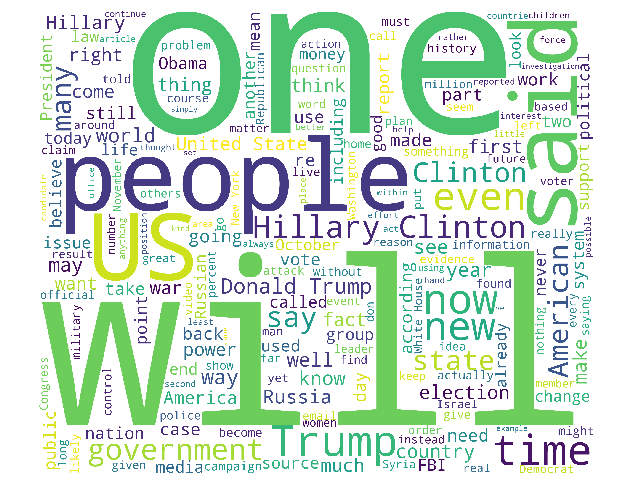

In [66]:
# subset for negative sentiment
df_cloud = df_train[df_train['label']=='FAKE']

# subset all words in text based on space
words = ' '.join(df_cloud['text'])

# split words
split_words = " ".join([word for word in words.split()])

# create wordcloud based on word frequancy
wordcloud = WordCloud(stopwords=STOPWORDS, # remove stopwords
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(split_words)

# plot wordcloud
plt.figure(1, figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### wordcloud - Real news
Most common word used in real news text bodies.

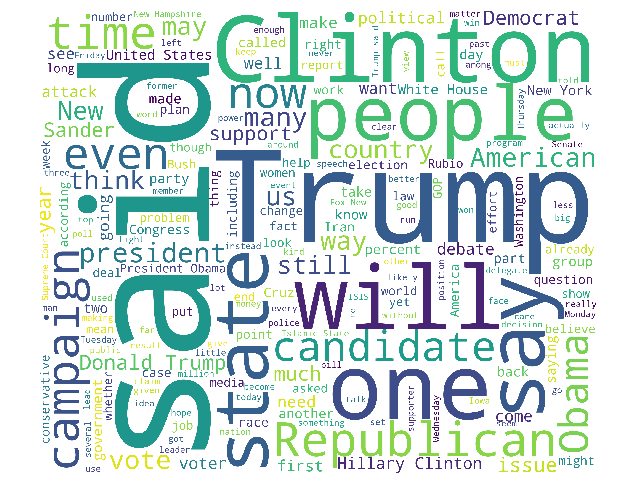

In [67]:
# subset for negative sentiment
df_cloud = df_train[df_train['label']=='REAL']

# subset all words in text based on space
words = ' '.join(df_cloud['text'])

# split words
split_words = " ".join([word for word in words.split()])

# create wordcloud based on word frequancy
wordcloud = WordCloud(stopwords=STOPWORDS, # remove stopwords
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(split_words)

# plot wordcloud
plt.figure(1, figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### normalize text
Lets try to structure the text and remove all unuseful elements to conduct a better analysis. Such as:
- Remove all but letters
- Tokenize words
- Convert to lowercase
- Filter stopwords
- Stem words with lemmatizer

In [284]:
# create new feature -> apply function on text
df_train['text_normalized'] = df_train.text.apply(normalizer)

# view reuslts
df_train[['text','text_normalized', 'label']].head(1)

text  \
ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

#### ngrams
As words mostly matter in context we'll look at bi, tri, quad-grams instead of just individual tokens.

In [283]:
# create new feature -> apply function on normalized_text
df_train['text_grams'] = df_train.text_normalized.apply(ngrams)

# view reuslts
df_train[['text_grams']].head(1)

,text_grams
ID,
8476,"[shillman journalism, journalism fellow, fellow freedom, freedom center, center new, new york, york writer, writer focusing, focusing radical, radical islam, islam final, final stretch, stretch election, election hillary, hillary rodham, rodham clinton, clinton gone, gone war, war fbi, fbi word, word unprecedented, unprecedented thrown, thrown around, around often, often election, election ought, ought retired, retired still, still unprecedented, unprecedented nominee, nominee major, major political, political party, party go, go war, war fbi, fbi thats, thats exactly, exactly hillary, hillary people, people done, done coma, coma patient, patient waking, waking watching, watching hour, hour cnn, cnn hospital, hospital bed, bed would, would assume, assume fbi, fbi director, director james, james comey, comey hillary, hillary opponent, opponent election, election fbi, fbi attack, attack everyone, everyone obama, obama cnn, cnn hillary, hillary people, people circulated, circulated letter, letter attacking, attacking comey, comey currently, currently medium, medium hit, hit piece, piece lambasting, lambasting targeting, targeting trump, trump wouldnt, wouldnt surprising, surprising clinton, clinton ally, ally start, start running, running attack, attack ad, ad fbi, fbi fbi, fbi leadership, leadership warned, warned entire, entire left, left wing, wing establishment, establishment form, form lynch, lynch mob, mob continue, continue going, going hillary, hillary fbi, fbi credibility, ...]"


#### frequency count - Fake news

In [70]:
# show 20 most common words form ngrams for fake news
df_train[(df_train.label == 'FAKE')][['text_grams']].apply(count_words)['text_grams'].most_common(20)

[('hillary clinton', 1469),
 ('donald trump', 1117),
 ('united state', 833),
 ('new york', 444),
 ('white house', 426),
 ('clinton campaign', 326),
 ('year old', 274),
 ('bill clinton', 259),
 ('presidential election', 245),
 ('clinton foundation', 237),
 ('american people', 234),
 ('secretary state', 233),
 ('wall street', 228),
 ('brain force', 210),
 ('http www', 202),
 ('year ago', 196),
 ('foreign policy', 189),
 ('http www com', 181),
 ('democratic party', 178),
 ('law enforcement', 176)]

#### frequency count - Real news

In [71]:
# show 20 most common words form ngrams for real news
df_train[(df_train.label == 'REAL')][['text_grams']].apply(count_words)['text_grams'].most_common(20)

[('donald trump', 1184),
 ('hillary clinton', 1118),
 ('united state', 1049),
 ('white house', 1022),
 ('new york', 987),
 ('fox news', 648),
 ('new hampshire', 634),
 ('president obama', 611),
 ('trump said', 497),
 ('islamic state', 494),
 ('secretary state', 467),
 ('supreme court', 465),
 ('ted cruz', 442),
 ('barack obama', 424),
 ('last week', 424),
 ('bernie sander', 419),
 ('foreign policy', 404),
 ('presidential candidate', 396),
 ('republican party', 394),
 ('south carolina', 353)]

#### Summary
Following the same break down as for titles but for our article text, we find the same results as for titles. 

*Noteworthy words for fake news:*
- wall street
- bill clinton
- year old

*Noteworthy words for real news:*
- fox news
- president obama
- new hampshire

## Further Analysis

### exclaimation couting
We want to inspect whether fake news use more exclaimation marks compared to real news. Thus we will create a new feature that contains the number of exclaimations marks used in each article. We will use this for both title and text.

In [267]:
df_train['ex_count'] = df_train.text.apply(exclaimation_counter)

In [281]:
df_train.groupby(['label', 'ex_count']).ex_count.count().unstack()

ex_count,0,1,2,3,4,5,6,7,8,9,10,11,12,14,19,27,40,54,58
label,,,,,,,,,,,,,,,,,,,
FAKE,1408.0,260.0,132.0,80.0,47.0,18.0,14.0,8.0,5.0,3.0,3.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0
REAL,1746.0,154.0,49.0,26.0,12.0,9.0,2.0,3.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [41]:
df_train.columns

Index(['title', 'text', 'label', 'X1', 'X2'], dtype='object')

### NaN Imputation

#### X1
Impute NaNs as unknown 